### Neural Style Transfer

Le neural style transfert est un type d'algorithme de Deep Learning qui permet la création d'images artistiques.
Concrétement nous partons de trois images:
* un content-image
* un style-image
* une image d'entrée (que je considère ici comme le content image)

L'algorithme va essayer de changer l'image d'entrée avec le contenu du ***content-image***, le style du ***style-image***.


Nous avons donc deux distances à minimiser:
* $D_c$: le content distance qui mesure la différence entre le contenu du ***content-image*** et celui de l'image d'entrée
* $D_s$: le style distance qui mesure la différence entre le style du ***style-image*** et celui de l'image d'entrée.

Il a été proposé par Leon A. Gatys, Alexander S. Ecker, Matthias Bethge dans l'article https://arxiv.org/pdf/1508.06576.pdf.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models


from PIL import Image


import os

In [2]:

#télécharge le style image s'il n'existe pas déjà
if 'starrynight.jpg' not in os.listdir():
    !wget https://oceanmhs.org/wp-content/uploads/2018/01/starrynight.jpg
    

In [3]:
#Je resize et standardise mes images
transform=transforms.Compose([transforms.Resize((128,128)),
                             transforms.ToTensor(),
                             transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                             ])


def load_image(pth):
    '''
    pth: le chemin de l'image
    '''
    image=Image.open(pth)
    return transform(image).unsqueeze(0)  #ajoute une dimension batch size


content_image=load_image('dancing.jpg')
style_image=load_image('starrynight.jpg')



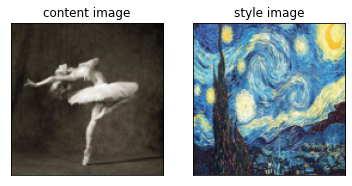

In [4]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]


unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],   #Pour mieux voir les images avec matplotlib
   std= [1/s for s in std])


def imshow(img,title=None):
    '''
    Cette procédure sert à visualiser les images
    
    '''
    img=unnormalize(img).squeeze(0)
    npimg = img.detach().numpy()
    npimg=npimg.clip(0,1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([]), plt.yticks([])
    if title!=None:
        plt.title(title)

        
        
        
plt.subplot(1,2,1)    
imshow(content_image, title='content image')  


plt.subplot(1,2,2)   
imshow(style_image, title='style image')

Pour faire le neural style transfer, nous allons utiliser un modèle déjà entraîné. On utilise ici VGG19 (https://arxiv.org/pdf/1409.1556.pdf) qui est utilisé dans le papier. 

Nous n'utilisons que les couches de convolution et pooling qui sont dans ***.features*** de notre modèle.

Nous n'avons également pas besoin de tracker le gradient.

In [5]:
modelVGG=models.vgg19(pretrained=True).features


for param in modelVGG.parameters(): #pas besoin du gradient
    param.requires_grad=False

In [6]:
print(modelVGG)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Les features maps obtenus après une couche de convolution sont une bonne représentation du contenu de l'image.Pour avoir le style nous allons calculer la corrélation entre les features (https://en.wikipedia.org/wiki/Gramian_matrix). Cela donne une représentation du style (https://fr.wikipedia.org/wiki/Texture_(traitement_des_images).


Nous calculons dans un premier temps:

1.  les features du content_image (nous choisissons une couche qui va représenter notre content)
2. le style image pour chaque couche de convolution à l'aide du gramian matrix (comme proposé dans le papier).


Nous prenons ensuite l'image d'entrée qu'on va entrainer sur le modèle. Nous utilisons l'optimiseur ADAM et le mseLoss. Le but est que notre image d'entrée matche au mieux le contenu du content-image et le style du style-image.


In [7]:
def get_features(model,image,layers):
    '''Cette fonction permet d'obtenir les features d'une image de certaines couches d'un model
    inputs:
        model: le modèle entrainé
        image: l'image sur laquelle nous voulons les features
        layers: (list) les couches
        
    outputs:
        features: les features
    
    '''
    features={}
    x=image;i=1
    for layer in range(len(model)):
        x=model[layer](x)
        if layer in layers:
            features['Conv_'+str(i)]=x  
            i+=1
    return features    
    

    

Pour une matrice X définie dans $\bf{R}^n$ muni du produit scalaire, le Gram matrix G est défini par:
$$G=X^TX$$

In [8]:
def gram_matrix(input):
    '''
    cette fonction prend en entrée une image et calcule le gramian matrix normalisé
    
    '''
    a,b,c,d=input.size()
    features=input.view(a*b,c*d) 
    return torch.mm(features,features.t()).div(a*b*c*d)  #on divise par a*b*c*d pour normaliser


layers=[0,5,10,19,28]  #Les couches de convolution utilisées, nous avons considéré les blocs (convolution, maxpool)
content_features=get_features(modelVGG,content_image,layers=layers)


style_features=get_features(modelVGG,style_image,layers=layers)
style_gram={k:gram_matrix(style_features[k]) for k in style_features.keys()}

Pour chaque couche de convolution, nous lui donnons un poids $w_l$=1/4 où 4 représente ici le nombre de couches de convolutions actives pour le style.

Nous avons également le content_weight qui est le poids du content loss, et le style_weight, le poids du style content.


$$Loss_{total}=content\_weight*content\_loss+ style\_weight * style\_loss$$ 


***Note***: le Conv_4 est choisi ici pour le content.

In [14]:
#J'ai pris ces valeurs comme dans le papier
style_weights = {'Conv_1': 1/4,
                 'Conv_2': 1/4,
                 'Conv_3': 1/4,
                 'Conv_5': 1/4}



#Les contributions de chaque loss dans le loss total
content_weight = 1  
style_weight = 1e9  


Nous partons du content_image comme image d'entrée.

Loss: 154590.171875


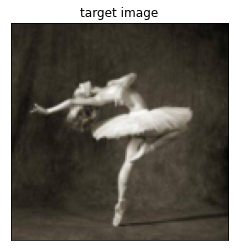

Loss: 26747.431640625


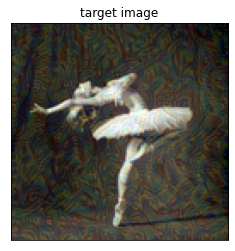

Loss: 13935.650390625


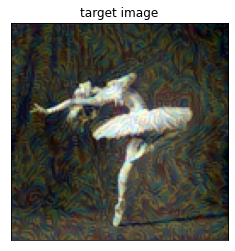

Loss: 9766.046875


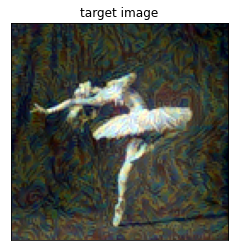

Loss: 7569.5634765625


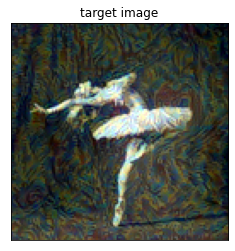

In [11]:
target=content_image.clone().requires_grad_(True)  #Nous partons de l'image content



optimizer=torch.optim.Adam([target],lr=0.003)  
epochs=500

for i in range(epochs):
    target_feature=get_features(modelVGG,target,layers) #récupère les features 
    content_loss=F.mse_loss(content_features['Conv_4'],target_feature['Conv_4'])  #calcule la différence entre le content feature et le target feature
    
    
    style_loss=0
    
    #Pour chaque couche, nous calculons le style representation
    for layer in style_weights:
        target_feat=target_feature[layer]
        target_gram=gram_matrix(target_feat) #les corrélations des features
        
        
        layer_style_loss=style_weights[layer]*F.mse_loss(target_gram,style_gram[layer])
        style_loss+=layer_style_loss  #on additionne les loss des différentes couches pour le style
        
    total_loss=content_weight*content_loss+style_weight*style_loss
    
    
    optimizer.zero_grad() #zero le gradient
    total_loss.backward() #calcule le gradient
    optimizer.step() #mis à jour des poids
    
    
    
    if i%100==0:
        print(f'Loss: {total_loss.item()}')
        imshow(target, title='target image') 
        plt.show()
        
    
    
        
    

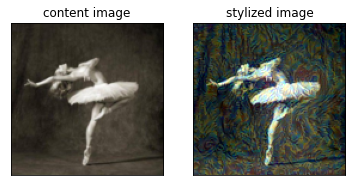

In [12]:
plt.subplot(1,2,1)    
imshow(content_image,title='content image')  

plt.subplot(1,2,2)    
imshow(target, title='stylized image')  


Stylized image est la variable d'entrée qui a récupéré le contenu du content image et le style du style image.

***Note***: Nous sommes partis du content image comme image d'entrée

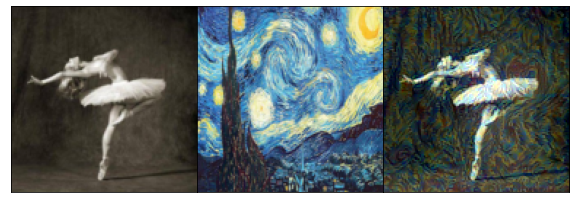

In [13]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)    
imshow(content_image)  

plt.subplot(1,3,2)    
imshow(style_image)  

plt.subplot(1,3,3)   
imshow(target)


plt.subplots_adjust(hspace=0,wspace=0)
plt.savefig('images.jpg',bbox_inches='tight')

### Sources
https://arxiv.org/pdf/1508.06576.pdf

https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

Cheikh TOURE